<a href="https://colab.research.google.com/github/edwin-19/TPU-TF-2/blob/master/Image_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# After installing this restart your colab
!pip install tpu_tf2
!pip install scikit-plot

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt
import os
from tpu_tf2.tpu import strategy
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_roc

seed = tf.random.set_seed(2021)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.215.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.215.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
print("Number of replica for TPU:", strategy.num_replicas_in_sync)

Number of replica for TPU: 8


# Load data

In [19]:
@tf.function
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0

  label = tf.squeeze(label, axis=0)
  return image, tf.one_hot(label, 10)

In [20]:
labels = {
    0:	"airplane",
    1:	"automobile",
    2:	"bird",
    3:	"cat",
    4:	"deer",
    5:	"dog",
    6:	"frog",
    7:	"horse",
    8:	"ship",
    9:	"truck"
}

In [21]:
seed
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(scale).batch(512).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(scale).batch(512).prefetch(tf.data.AUTOTUNE)

# Build Model

In [23]:
seed
with strategy.scope():
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.applications.ResNet101V2(include_top=False, input_shape=(224, 224, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax()
  ])
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 re_lu_1 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
 softmax_1 (Softmax)         (None, 10)                0         
                                                      

In [25]:
seed
history = model.fit(
    train_ds, epochs=20, validation_data=test_ds, use_multiprocessing=True, workers=10
)

Epoch 1/20
98/98 [==============================] - 220s 1s/step - loss: 0.4117 - accuracy: 0.8658 - val_loss: 0.2670 - val_accuracy: 0.9235
Epoch 2/20
98/98 [==============================] - 39s 395ms/step - loss: 0.0682 - accuracy: 0.9778 - val_loss: 0.2048 - val_accuracy: 0.9443
Epoch 3/20
98/98 [==============================] - 40s 405ms/step - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.1862 - val_accuracy: 0.9494
Epoch 4/20
98/98 [==============================] - 39s 395ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.2013 - val_accuracy: 0.9472
Epoch 5/20
98/98 [==============================] - 39s 395ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.2216 - val_accuracy: 0.9454
Epoch 6/20
98/98 [==============================] - 39s 396ms/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.2152 - val_accuracy: 0.9476
Epoch 7/20
98/98 [==============================] - 39s 397ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.2099 - val_accuracy: 0.9491
E

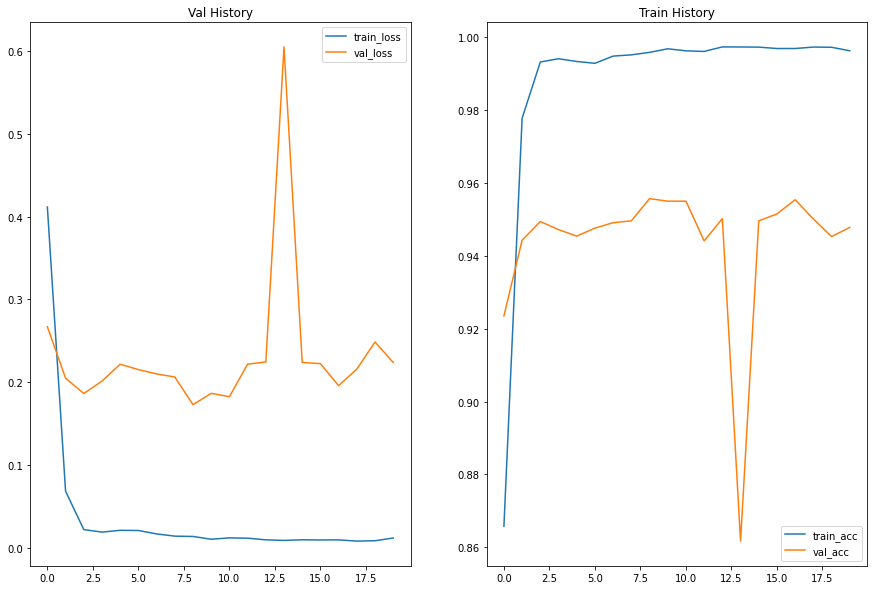

In [26]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Val History')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Train History')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Evaluate Model

In [27]:
seed
predictions = model.predict(test_ds, verbose=1)

20/20 [==============================] - 22s 922ms/step


In [28]:
y_true = np.concatenate(y_test)
y_pred = predictions.argmax(axis=1)

In [29]:
print(classification_report(y_true, y_pred, target_names=list(labels.values())))

              precision    recall  f1-score   support

    airplane       0.93      0.98      0.96      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.98      0.89      0.93      1000
         cat       0.86      0.91      0.89      1000
        deer       0.94      0.97      0.95      1000
         dog       0.93      0.90      0.92      1000
        frog       0.97      0.96      0.97      1000
       horse       0.98      0.96      0.97      1000
        ship       0.98      0.96      0.97      1000
       truck       0.95      0.97      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



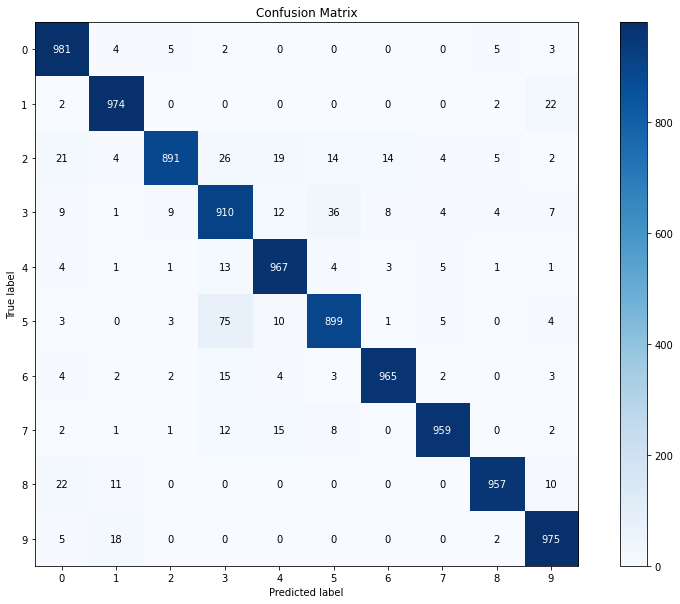

In [30]:
plot_confusion_matrix(y_true, y_pred, figsize=(15, 10))

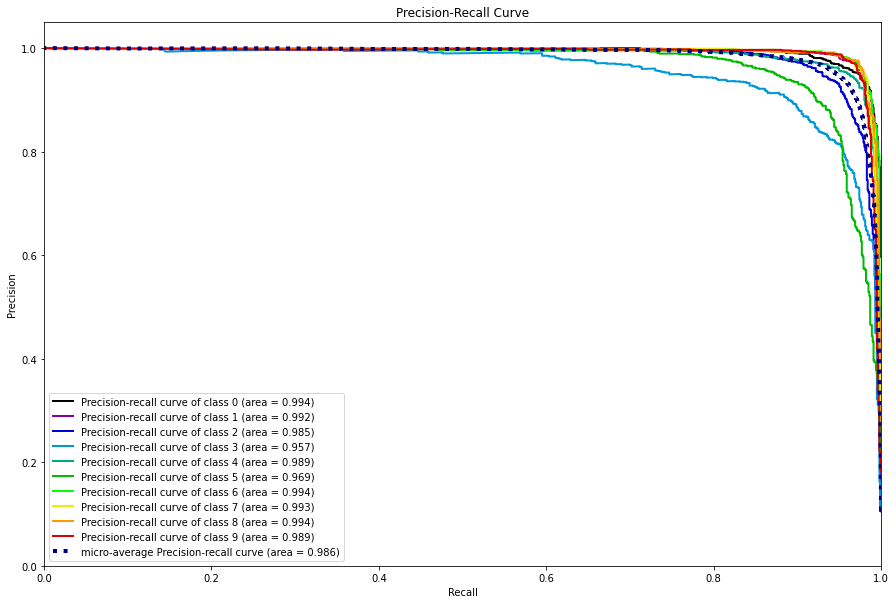

In [31]:
plot_precision_recall(y_true, predictions, figsize=(15, 10))

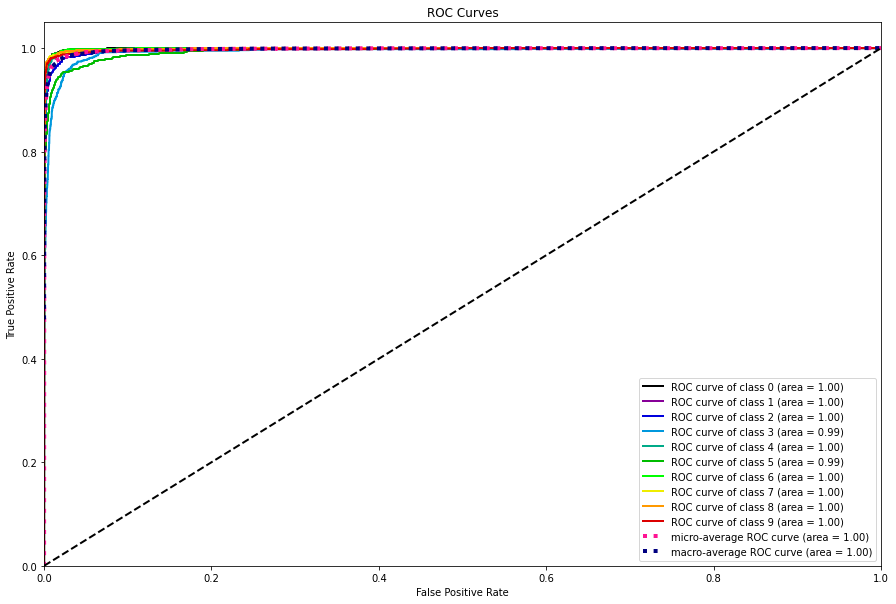

In [32]:
plot_roc(y_true, predictions, figsize=(15, 10))

In [33]:
print('MCC: {}'.format(matthews_corrcoef(y_true, y_pred)))

MCC: 0.9420920259502217
